In [1]:
!pip install -q --upgrade ultralytics 
!pip install -q --upgrade -U ray[tune]

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

%matplotlib inline

!wandb disabled # use if you have Weights and Biases installed


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
W&B disabled.


In [3]:
class CFG:
    DEBUG = False # Set to True to make quick experiments
    FRACTION = 0.05 if DEBUG else 1.0 # Specifies the fraction of the dataset to use for training. Allows for training on a subset of the full dataset, useful for experiments or when resources are limited.
    SEED = 42

    # classes
    CLASSES = ['door', 'cabinetDoor', 'refrigeratorDoor', 'window',
               'chair', 'table', 'cabinet',
               'couch', 'openedDoor', 'pole']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 50 # 100
    BATCH_SIZE = -1 
    
    BASE_MODEL = 'yolov9e' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'AdamW' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01 # Final learning rate as a fraction of the initial rate = (lr0 * lrf), used in conjunction with schedulers to adjust the learning rate over time.
    WEIGHT_DECAY = 0.01 if DEBUG else 0.0005 # L2 regularization term, penalizing large weights to prevent overfitting.
    DROPOUT = 0.2
    PATIENCE = 2 if DEBUG else 10
    PROFILE = False
    LABEL_SMOOTHING = 0.1

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/indoor-object-detection'
    OUTPUT_DIR = '/kaggle/working/'

In [4]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)


In [5]:
# read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

# print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)


names:
- door
- cabinetDoor
- refrigeratorDoor
- window
- chair
- table
- cabinet
- couch
- openedDoor
- pole
nc: 10
test: /kaggle/input/indoor-object-detection/test
train: /kaggle/input/indoor-object-detection/train
val: /kaggle/input/indoor-object-detection/valid



Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> \n
Shape:  (683, 1024, 3) \n


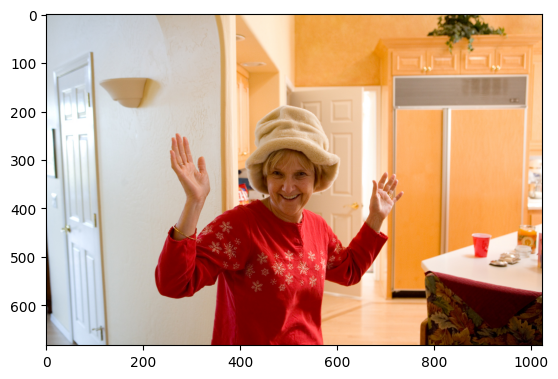

In [6]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\\n')
        print('Shape: ', np.array(img).shape, '\\n')

    if hide_axis:
        plt.axis('off')

    plt.show()
    
   
example_image_path = CFG.CUSTOM_DATASET_DIR + '/train/images/000c052bb4b882c4.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)


In [7]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties
    
img_properties = get_image_properties(example_image_path)
img_properties


{'width': 1024, 'height': 683, 'channels': 3, 'dtype': dtype('uint8')}

In [8]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None): 
    display(dataset_stats_df)



,Mode,door,cabinetDoor,refrigeratorDoor,window,chair,table,cabinet,couch,openedDoor,pole,Data_Volume
0,train,309,448,332,187,105,165,138,22,68,14,1008
1,valid,63,99,85,39,24,30,28,1,13,4,230
2,test,25,42,1,49,38,41,44,31,18,3,104


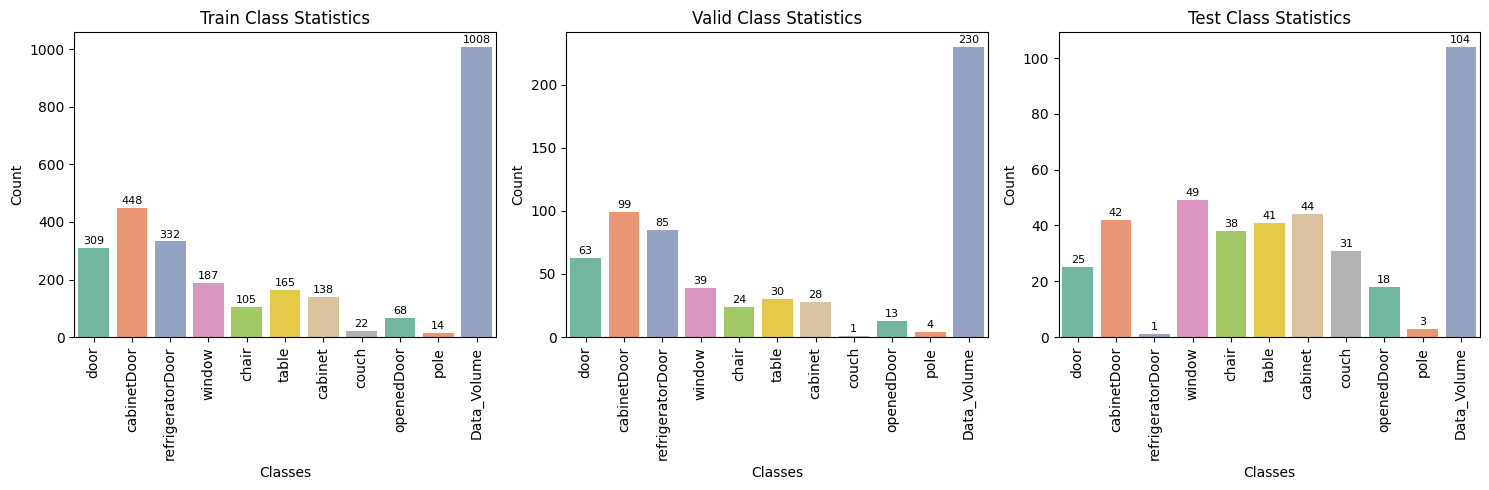

In [9]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()



WARNING ⚠️ imgsz=[683, 1024] must be multiple of max stride 32, updating to [704, 1024]
image 1/1 /kaggle/input/indoor-object-detection/train/images/000c052bb4b882c4.jpg: 704x1024 1 person, 117.8ms
Speed: 9.5ms preprocess, 117.8ms inference, 505.5ms postprocess per image at shape (1, 3, 704, 1024)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels
Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> \n
Shape:  (683, 1024, 3) \n


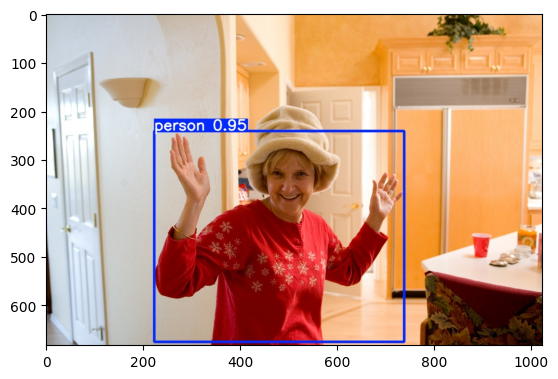

In [10]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,
    classes = [0],
    conf = 0.30,
#     device = [0,1], # inference with dual GPU
    device = None, # inference with CPU
    imgsz = (img_properties['height'], img_properties['width']),
    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'runs/detect/predict/{example_image_inference_output}')


In [11]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)


In [12]:
%%time

model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,
    
    val = True,
    amp = True,    
    exist_ok = True,
    resume = False,
    device = [0], #  [0,1] 
#     device = None, # CPU run
    verbose = False,
)


Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=/kaggle/working/data.yaml, epochs=50, time=None, patience=10, batch=-1, imgsz=(683, 1024), save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=yolov9e_ppe_css_50_epochs, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_

100%|██████████| 755k/755k [00:00<00:00, 16.8MB/s]
2024-11-23 22:55:54,156	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-23 22:55:54,407	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1         0  torch.nn.modules.linear.Identity             []                            
  1                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  2                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  3                  -1  1    252160  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 2]        
  4                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  5                  -1  1   1004032  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 2]       
  6                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  7                  -1  1   4006912  ultralytic

train: Scanning /kaggle/input/indoor-object-detection/train/labels... 1008 images, 120 backgrounds, 0 corrupt: 100%|██████████| 1012/1012 [00:04<00:00, 228.74it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=1024 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.74G total, 1.16G reserved, 0.48G allocated, 13.11G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    58152622       493.3         3.647         165.7         280.3      (1, 3, 1024, 1024)                    list
    58152622       986.7         6.547         182.2         211.5      (2, 3, 1024, 1024)                    list
    58152622        1973        12.359         366.1         383.4      (4, 3, 1024, 1024)                    list
CUDA out of memory. Tried to allocate 

train: Scanning /kaggle/input/indoor-object-detection/train/labels... 1008 images, 120 backgrounds, 0 corrupt: 100%|██████████| 1012/1012 [00:01<00:00, 621.78it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/indoor-object-detection/valid/labels... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:01<00:00, 209.78it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/valid is not writeable, cache not saved.


Plotting labels to runs/detect/yolov9e_ppe_css_50_epochs/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/yolov9e_ppe_css_50_epochs
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.11G      1.872      3.469      2.029         14       1024: 100%|██████████| 506/506 [05:03<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:20<00:00,  2.77it/s]

                   all        230       1289       0.43        0.1     0.0475     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.09G      1.909      3.457      2.111         14       1024: 100%|██████████| 506/506 [04:59<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:19<00:00,  3.04it/s]

                   all        230       1289       0.65     0.0463     0.0428     0.0191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.07G      1.868      3.268      2.092         43       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]

                   all        230       1289      0.351     0.0898     0.0596     0.0284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       8.1G      1.835      3.202      2.054         21       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.08it/s]

                   all        230       1289      0.391     0.0899     0.0687     0.0326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.09G      1.777      3.059      1.979         10       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]

                   all        230       1289      0.387       0.11     0.0822     0.0428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.28G      1.749      2.967      1.953          3       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:19<00:00,  3.05it/s]

                   all        230       1289      0.412      0.111     0.0858     0.0437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.08G      1.677      2.925      1.913         13       1024: 100%|██████████| 506/506 [04:57<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]

                   all        230       1289      0.411      0.128      0.101     0.0534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.07G      1.698      2.819      1.921         13       1024: 100%|██████████| 506/506 [04:57<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]

                   all        230       1289      0.501      0.119     0.0941     0.0499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       8.1G      1.645      2.749      1.877         20       1024: 100%|██████████| 506/506 [04:57<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]

                   all        230       1289      0.424       0.13      0.109     0.0593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.27G      1.645      2.741      1.888          4       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.06it/s]

                   all        230       1289      0.613      0.135      0.106     0.0564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.09G      1.615      2.696      1.831         41       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.08it/s]

                   all        230       1289      0.623        0.1      0.112     0.0599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.08G      1.608      2.844      1.855         17       1024: 100%|██████████| 506/506 [04:57<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]

                   all        230       1289      0.609      0.137      0.121     0.0658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.08G      1.602       2.63      1.833         31       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]

                   all        230       1289      0.641      0.156      0.123     0.0681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       8.1G      1.603      2.709      1.828         12       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]

                   all        230       1289      0.541      0.138       0.12     0.0645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.08G      1.574      2.589      1.838         29       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]

                   all        230       1289      0.708      0.119      0.126     0.0691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.76G      1.557      2.639      1.809          9       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]

                   all        230       1289      0.646      0.149      0.129       0.07



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.08G      1.562      2.431      1.803         10       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]

                   all        230       1289       0.66      0.148      0.134     0.0736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.08G      1.516       2.47      1.779         31       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.08it/s]

                   all        230       1289      0.568      0.173      0.148     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       8.1G      1.517      2.404      1.777         10       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.10it/s]

                   all        230       1289      0.686      0.122      0.136     0.0751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       8.1G      1.519       2.42      1.761         33       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]

                   all        230       1289      0.663       0.16       0.15     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.75G      1.502      2.391      1.756         21       1024: 100%|██████████| 506/506 [04:57<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.08it/s]

                   all        230       1289      0.666      0.162      0.142     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.75G      1.497      2.316      1.751          7       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]

                   all        230       1289      0.448      0.189      0.156     0.0851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.08G      1.508      2.377      1.767          6       1024: 100%|██████████| 506/506 [04:57<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]

                   all        230       1289      0.557      0.185       0.15     0.0836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.08G      1.498      2.291      1.756         37       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]

                   all        230       1289      0.677       0.15      0.161     0.0861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       8.1G      1.511      2.291      1.755         15       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]

                   all        230       1289      0.574       0.18      0.153     0.0857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.09G      1.473      2.287      1.727         42       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]

                   all        230       1289      0.669       0.17       0.17     0.0954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.09G       1.48      2.204      1.743         13       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]

                   all        230       1289      0.683      0.179      0.174     0.0936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.09G      1.454      2.237      1.719         54       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.08it/s]

                   all        230       1289      0.549      0.194      0.156      0.087



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.07G      1.451      2.195      1.712          5       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]

                   all        230       1289      0.672      0.161      0.163      0.089



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       8.1G      1.449      2.226      1.708         13       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.08it/s]

                   all        230       1289      0.549      0.225      0.187      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.78G      1.431      2.176       1.71         21       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.08it/s]

                   all        230       1289        0.6      0.184       0.19      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.08G      1.458      2.133      1.718         45       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]

                   all        230       1289      0.483      0.198      0.193      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       8.1G      1.425      1.999      1.667         17       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]

                   all        230       1289      0.582      0.214      0.188      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.27G      1.437       2.07      1.695         50       1024: 100%|██████████| 506/506 [04:57<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]

                   all        230       1289      0.611      0.192        0.2       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       8.1G      1.406      2.037       1.65          5       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.10it/s]

                   all        230       1289      0.507      0.207      0.204      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.09G      1.393      1.973      1.669         24       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]

                   all        230       1289       0.49      0.216        0.2      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.78G      1.393      2.012      1.661         18       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]

                   all        230       1289      0.651      0.207      0.221      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       7.3G      1.388      1.944      1.642         21       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]

                   all        230       1289      0.507      0.242      0.206      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.09G      1.389      1.938      1.644         10       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.08it/s]

                   all        230       1289      0.507      0.233      0.214      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       8.1G      1.363      1.936      1.631         51       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]

                   all        230       1289       0.54      0.233      0.214      0.118


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.09G       1.38      2.152       1.65          1       1024: 100%|██████████| 506/506 [04:58<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.07it/s]

                   all        230       1289      0.586      0.219       0.22      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       7.3G      1.363      2.021       1.62          3       1024: 100%|██████████| 506/506 [04:57<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]

                   all        230       1289      0.517      0.232      0.216      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.09G      1.341       2.09      1.643          6       1024: 100%|██████████| 506/506 [04:57<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.08it/s]

                   all        230       1289      0.507      0.235      0.204      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.08G      1.356      1.956      1.631          5       1024: 100%|██████████| 506/506 [04:57<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]

                   all        230       1289      0.545      0.226       0.21      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.09G      1.332      1.982      1.643         16       1024: 100%|██████████| 506/506 [04:57<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]

                   all        230       1289      0.556      0.222      0.218      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       8.1G      1.317      1.875       1.61         22       1024: 100%|██████████| 506/506 [04:57<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.08it/s]

                   all        230       1289      0.543      0.267      0.234      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.29G       1.31      1.823      1.601         10       1024: 100%|██████████| 506/506 [04:57<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]

                   all        230       1289      0.557      0.262      0.237      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       8.1G      1.305      1.801      1.605          5       1024: 100%|██████████| 506/506 [04:57<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]

                   all        230       1289      0.544      0.267      0.238      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.08G       1.29      1.831       1.59          4       1024: 100%|██████████| 506/506 [04:57<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.10it/s]

                   all        230       1289      0.551       0.26      0.232      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       8.1G      1.291      1.765      1.578          9       1024: 100%|██████████| 506/506 [04:57<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:18<00:00,  3.10it/s]

                   all        230       1289      0.561      0.256      0.237      0.138



50 epochs completed in 4.448 hours.
Optimizer stripped from runs/detect/yolov9e_ppe_css_50_epochs/weights/last.pt, 117.3MB
Optimizer stripped from runs/detect/yolov9e_ppe_css_50_epochs/weights/best.pt, 117.3MB

Validating runs/detect/yolov9e_ppe_css_50_epochs/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9e summary (fused): 687 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:17<00:00,  3.34it/s]


                   all        230       1289      0.544      0.267      0.238      0.139
Speed: 0.4ms preprocess, 70.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/yolov9e_ppe_css_50_epochs
CPU times: user 3h 30min 19s, sys: 1h 22s, total: 4h 30min 41s
Wall time: 4h 28min 6s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d79c61eaa40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [13]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)


Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ imgsz=[683, 1024] must be multiple of max stride 32, updating to [704, 1024]
YOLOv9e summary (fused): 687 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs

PyTorch: starting from 'runs/detect/yolov9e_ppe_css_50_epochs/weights/best.pt' with input shape (1, 3, 704, 1024) BCHW and output shape(s) (1, 14, 14784) (111.9 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: export success ✅ 9.1s, saved as 'runs/detect/yolov9e_ppe_css_50_epochs/weights/best.onnx' (219.4 MB)

Export complete (21.5s)
Results saved to /kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov9e_ppe_css_50_epochs/weights/best.onnx imgsz=704,1024  
Validate:        yolo val task=detect model=runs/detect/yolov9e_ppe_css_50_epochs/weights/best.onnx imgsz=704,1024 data=/kaggle/working/data.yaml  WARNING ⚠️ non-PyTorch val requires square images, 'imgs

'runs/detect/yolov9e_ppe_css_50_epochs/weights/best.onnx'

In [14]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths


['/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/confusion_matrix_normalized.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/R_curve.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/results.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/P_curve.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/F1_curve.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/confusion_matrix.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/PR_curve.png',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/labels.jpg',
 '/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/labels_correlogram.jpg']

/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/F1_curve.png


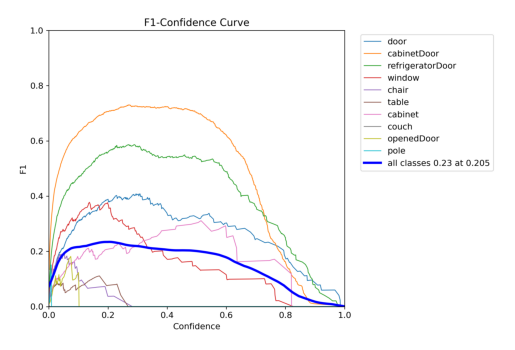

\n
/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/PR_curve.png


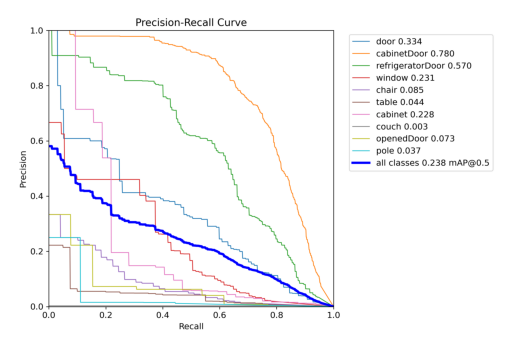

\n
/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/P_curve.png


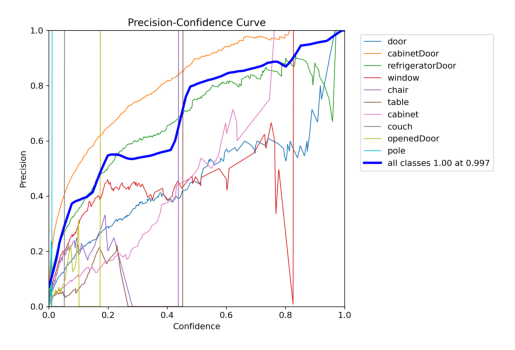

\n
/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/R_curve.png


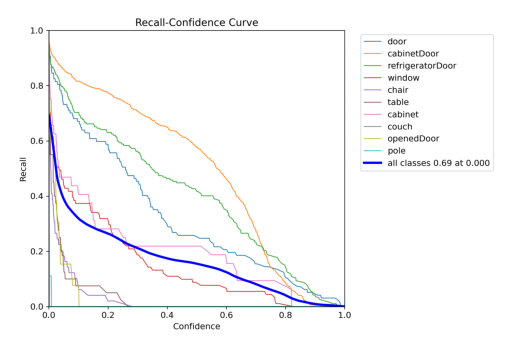

\n
/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/confusion_matrix.png


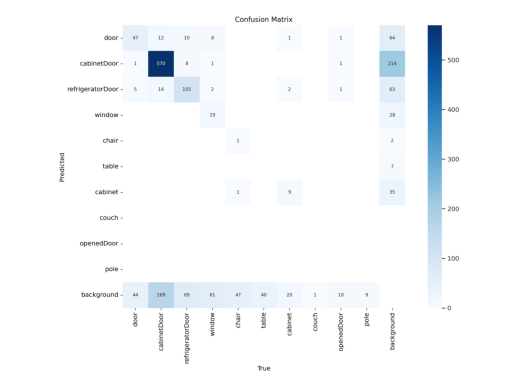

\n
/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/confusion_matrix_normalized.png


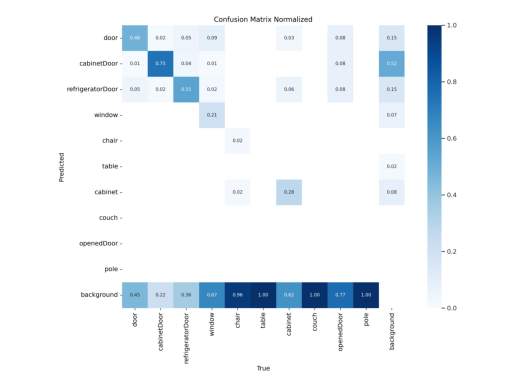

\n
/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/labels.jpg


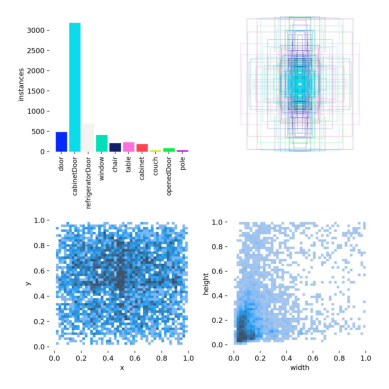

\n
/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/labels_correlogram.jpg


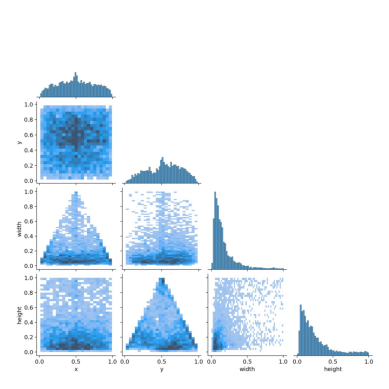

\n
/kaggle/working/runs/detect/yolov9e_ppe_css_50_epochs/results.png


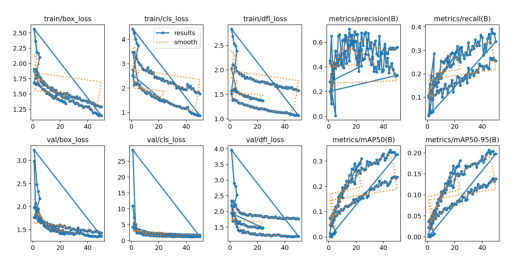

\n


In [15]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\\n')


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> \n
Shape:  (1920, 1920, 3) \n


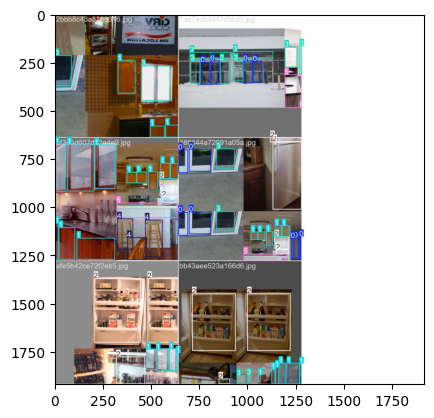

In [7]:
# example_image_inference_output = example_image_path.split('/')[-1]
display_image('/kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/train_batch2.jpg')


# Аналіз отриманих результатів

## Порівняння очікуваних результатів з отриманими

| **Метрика**                           | **Очікувані результати**                              | **Отримані результати**                              |
|---------------------------------------|-----------------------------------------------------|-----------------------------------------------------|
| **Mean Average Precision (mAP)**      |                                                     |                                                     |
| Загальний mAP@0.5                     | 40-60%                                              | ~24%                                               |
| mAP@0.5:0.95                          | 25-40%                                              | ~14%                                               |
| **Точність (Precision) для класів**   |                                                     |                                                     |
| Найпростіші об'єкти (двері, вікна)    | 60-75%                                              | 33-78%                                             |
| Складніші об'єкти (стільці, столи)    | 50-65%                                              | 4-23%                                              |
| Найскладніші об'єкти (відкриті двері, дверцята шафи) | 40-55%                            | 0.3-7%                                               |
| **Повнота (Recall) для класів**       | 50-70%                                              | ~27%                                               |
| **F1-score**                          | У середньому по всіх класах: 45-60%                 | У середньому по всіх класах: ~23%                                               |
| **Загальна точність (Precision)**     | 55-70%                                              | ~54%                                                |


Отримана модель є недотренованою.
На 50-тій епосі модель все ще показує здатність до зростання показників (втрати падають, Precision і Recall повільно ростуть), тому гіпотетично, якщо збільшити кількість епох до 100, ми б цілком можливо могли отримати шукані метрики. Проте час тренування на 50-ти епохах зайняв 4.5 години, і з ціллю збереження наявного ресурсу gpu платформи я зупинила екперимент. 

Наразі модель досить добре справляється з найбільш представленими в наборі даних класами і пропорційно гіршає у визначенні найменш представлених класів. Тобто у нас є проблема дисбалансу класів. Наприклад, cabinetDoor має досить гарний предікшн, але згідно з аналізу розподілу вхідних даних і Confusion matrix бачимо, що це виникає тому, що модель віддає найбільш представленому класу (cabinetDoor) найбільшу ймовірність. Тобто у нас досить висока частка зображень, хибно позитивно класифікованих.

З наявних результатів також бачимо, що найчастіше між собою плутаються door та window, а також door і refrigeratorDoor. Причиною плутанин є візуальна схожість, але також причиною плутанини є певна недетермінованість задачі, бо класс door є занадто широким, і включає у себе cabinetDoor, refrigeratorDoor, openedDoor, і в певному сенсі window також, бо є, наприклад, балконні двері.

### Потенційні оптимізації тренування з можливим впливом на показники моделі:
1. Експерименти з розміром зображення: більші зображення містять більше інформації, яка може бути як релевантною, так і ні. Тобто відкидання зайвого шуму в зображеннях (наприклад, за рахунок зменшення розміру чи фільтрації нерелевантних областей) може покращити здатність моделі до узагальнення та точності прогнозів.
2. Змінити триканальний формат на одноканальний за рахунок переходу зображення у чорнобілий режим. Це зменшить кількість ресурсів, що витрачається на навчання, але може погіршити метрики моделі. 
3. Збільшення параметра WEIGHT_DECAY до 0.001 могло б додати більшого штрафу для loss function і привидшити навчання, так само як і зміна learning rate параметрів. Але варто зважати на ризик проскочити оптимальне рішення через завеликий learning rate.

### Можливі рішення для покращення моделі:
1. Донавчання моделі з:
 - Збільшення кількості даних для менш представлених класів.
 - Додавання ваг для менш представлених класів у функцію втрат і зменшення ваги добре класифікованих прикладів, щоб модель краще зосереджувалась на важких прикладах.
   
2. Заміна категорії door на кілька окремих підкатегорій або об’єднання подібних класів (наприклад, різні типи door у єдиний клас door).

3. Використати техніку transfer learning, почавши з попередньо натренованої моделі (наприклад, на COCO), що може покращити початкові метрики.

